In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import keras
import tensorflow as tf

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [5]:
genre_response = requests.get("https://api.themoviedb.org/3/genre/movie/list?api_key=50298e4210ad98f9daba9b5d76b15889&language=en-US")
all_genres = genre_response.json()["genres"]
# for i,v in enumerate(all_genres):
#     v["id"] = i

all_genres

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 16, 'name': 'Animation'},
 {'id': 35, 'name': 'Comedy'},
 {'id': 80, 'name': 'Crime'},
 {'id': 99, 'name': 'Documentary'},
 {'id': 18, 'name': 'Drama'},
 {'id': 10751, 'name': 'Family'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 36, 'name': 'History'},
 {'id': 27, 'name': 'Horror'},
 {'id': 10402, 'name': 'Music'},
 {'id': 9648, 'name': 'Mystery'},
 {'id': 10749, 'name': 'Romance'},
 {'id': 878, 'name': 'Science Fiction'},
 {'id': 10770, 'name': 'TV Movie'},
 {'id': 53, 'name': 'Thriller'},
 {'id': 10752, 'name': 'War'},
 {'id': 37, 'name': 'Western'}]

In [6]:
def build_url(params, pages=1):
    url = "https://api.themoviedb.org/3/discover/movie?api_key=50298e4210ad98f9daba9b5d76b15889&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&with_watch_monetization_types=flatrate"
    url += f"&with_genres={params}&page={pages}"
    return url

In [7]:
def get_movie_data(genre, pages):
    response = requests.get(build_url(genre, pages))
    return response.json()


In [8]:
# data = get_movie_data(28,pages)

In [9]:
movies_data = pd.DataFrame(columns=["movie_name", "plot", "genre"])

In [10]:
def load_movies_data(genre, pages):
    data = pd.DataFrame(columns=["movie_name", "plot", "genre"])
    for i in get_movie_data(genre, pages)["results"]:
        # print({"movie_name" : i["original_title"], "plot": i["overview"], "genre": i["genre_ids"]})
        data =  pd.concat([data, pd.DataFrame.from_records([{"movie_name" : i["original_title"], "plot": i["overview"], "genre": i["genre_ids"], "primary_genre": genre}])])
    return data

In [11]:
DATA_LIMIT = 2000

In [12]:
# num_of_genres = 0
# for i in all_genres:
#     num_of_genres+=1
#     pages =1
#     while(movies_data.shape[0] < (DATA_LIMIT * num_of_genres)):
#         movies_data = pd.concat([movies_data, load_movies_data(i['id'], pages)])
#         pages += 1

movies_data = pd.read_csv("scrubedData.csv")

In [13]:
# movies_data.to_csv("scrubedData.csv")

In [14]:
movies_data.shape

(38000, 5)

In [15]:
movies_data.head()

,Unnamed: 0,movie_name,plot,genre,primary_genre
0,0,Spider-Man: No Way Home,peter parker unmasked longer able separate nor...,"[28, 12, 878]",28.0
1,0,Sonic the Hedgehog 2,settling green hills sonic eager prove takes t...,"[28, 878, 35, 10751]",28.0
2,0,Moonfall,mysterious force knocks moon orbit around eart...,"[28, 12, 878]",28.0
3,0,War of the Worlds: Annihilation,mother son find faced brutal alien invasion su...,"[878, 28]",28.0
4,0,The Adam Project,accidentally crash landing time traveling figh...,"[28, 12, 35, 878]",28.0


In [16]:
stop_words = stopwords.words('english')
stop_words.extend(["br"]) # Added the line break tag br to the stop words as it is not necessary
stop_words = set(stop_words)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatize(word):
    return lemmatizer.lemmatize(word)

def clean_text(text):
    text = str(text).lower().split()
    
    stops = stop_words
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)
    
    text = re. sub(r'https?://[A-Za-z0-9./]+', 'url', text)
    text = re. sub(r"[^A-Za-z0-g^,!.V'+-=]"," ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re. sub(r"\'ve", "have", text)
    text = re.sub(r"n't", "not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re. sub(r"\'re", "are", text)
    text = re.sub(r"\'d", "would", text)
    text = re.sub(r"\'ll", "will", text)
    text = re.sub(r",", " ",text)
    text = re.sub(r"\.", " ",text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re. sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + " , text)
    text = re.sub(r"\-", " - " , text)
    text = re.sub(r"\=", " = " , text)
    text = re. sub(r"'", " " , text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re. sub(r":", " : ", text)
    text = re. sub(r" e g ", " eg ", text)
    text = re. sub(r" b g ", " bg ", text)
    text = re. sub(r"j k", " jk ", text)
    text = re. sub(r" u s ", " american ", text)
    text = re. sub(r"\0s", "0", text)
    text = re. sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re. sub(r'(\w)\1{2,}', r'\1\1', text)
    text = re.sub(r'\w(\w)\1{2}','', text)
    pattern = re.compile(r"(.)\1{2,}")
    text = pattern.sub(r"\1\1", text)
    stemmer.stem(text)
    return lemmatize(text)

def del_NonAlphawords(sentence):
    return " ".join([word for word in sentence.split() if word.isalpha()])

In [17]:
clean_all = lambda x : del_NonAlphawords(clean_text(x))

In [18]:
movies_data["plot"] = movies_data["plot"].apply(clean_all)

<AxesSubplot:>

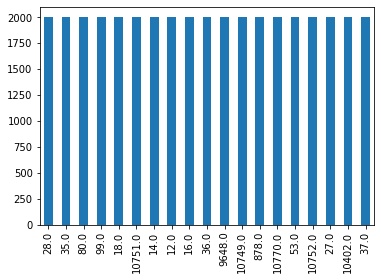

In [19]:
movies_data.primary_genre.value_counts().sort_values().plot(kind = 'bar')

In [20]:
# movies_data = movies_data.explode("genre")

In [21]:
# movies_data.genre.value_counts().sort_values().plot(kind = 'bar')

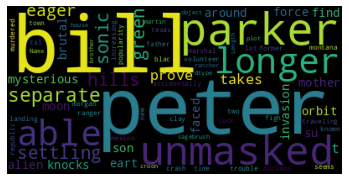

In [22]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt



wordcloud = WordCloud().generate(str(movies_data["plot"]))

plt.figure()
plt.imshow(wordcloud)

plt.axis("off")

plt.show()

In [23]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(movies_data["plot"])
word_index = tokenizer.word_index

In [24]:
path_to_glove_file = os.path.join("glove.42B.300d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1917494 word vectors.


In [25]:
num_tokens = len(word_index) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 42121 words (2211 misses)


In [26]:
classes = np.unique(movies_data["primary_genre"])
classes

array([   12.,    14.,    16.,    18.,    27.,    28.,    35.,    36.,
          37.,    53.,    80.,    99.,   878.,  9648., 10402., 10749.,
       10751., 10752., 10770.])

In [27]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
# from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
import os
from tensorflow.keras.callbacks import TensorBoard



encoder = LabelEncoder()
encoder.fit(movies_data["primary_genre"])
y_data = encoder.transform(movies_data["primary_genre"])

categorical_labels = to_categorical(y_data,num_classes=len(classes))
X_train, X_test, Y_train, Y_test = train_test_split(movies_data["plot"], categorical_labels, test_size=0.2)

In [28]:
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
MAX_SEQUENCE_LENGTH = 10000

In [30]:
pad_X_train = pad_sequences(
   tokenizer.texts_to_sequences(X_train), maxlen = MAX_SEQUENCE_LENGTH
 )
pad_X_test =  pad_sequences(
     tokenizer.texts_to_sequences(X_test), maxlen = MAX_SEQUENCE_LENGTH
   )

In [31]:
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:
my_tags = np.unique(movies_data["primary_genre"])

In [33]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [34]:
batch_size=64
epochs = 100

In [35]:
pad_X_train[0].shape

(10000,)

In [36]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [37]:
# Build the model
with tf.device('/cpu:0'):
    model = Sequential()
    model.add(Dense(512, input_shape=pad_X_train[0].shape))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    # model.add(Dense(np.unique(movies_data["primary_genre"]).shape[0]))
    # model.add(Activation('softmax'))
    model.add(Dense(np.unique(movies_data["primary_genre"]).shape[0],activation='softmax'))


    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
                
    history = model.fit(pad_X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.1)

Metal device set to: AMD Radeon Pro 5300M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB

Epoch 1/100


2022-04-16 22:55:24.995356: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-16 22:55:24.997975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-16 22:55:24.998621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


428/428 [==============================] - 9s 21ms/step - loss: 111.2195 - accuracy: 0.0561 - val_loss: 4.2588 - val_accuracy: 0.0622
Epoch 2/100
428/428 [==============================] - 8s 20ms/step - loss: 3.8181 - accuracy: 0.0550 - val_loss: 3.4655 - val_accuracy: 0.0500
Epoch 3/100
428/428 [==============================] - 9s 20ms/step - loss: 3.3661 - accuracy: 0.0556 - val_loss: 3.3553 - val_accuracy: 0.0487
Epoch 4/100
428/428 [==============================] - 9s 20ms/step - loss: 3.1301 - accuracy: 0.0554 - val_loss: 3.4287 - val_accuracy: 0.0470
Epoch 5/100
428/428 [==============================] - 9s 20ms/step - loss: 3.0774 - accuracy: 0.0544 - val_loss: 3.1738 - val_accuracy: 0.0477
Epoch 6/100
428/428 [==============================] - 9s 20ms/step - loss: 3.0088 - accuracy: 0.0551 - val_loss: 3.1229 - val_accuracy: 0.0474
Epoch 7/100
428/428 [==============================] - 9s 20ms/step - loss: 2.9773 - accuracy: 0.0546 - val_loss: 3.1573 - val_accuracy: 0.0477
Ep